# Game Board Initialization and Rendering

In [173]:
import numpy as np
import random
import pygame
import time
import pickle
from collections import defaultdict
from enum import Enum
from IPython.display import display, Image
import os
import math

In [174]:
# Constants
class Stones(Enum):
    EMPTY = 0
    WHITE = 1
    BLACK = 2

KEWAI_RADIUS = 25
BOARD_RADIUS = KEWAI_RADIUS * 5
SCREEN_SIZE = (BOARD_RADIUS + KEWAI_RADIUS * 2) * 2
BACKGROUND_COLOR = "azure2"
LINE_COLOR = "black"
BOARD_LINE_WIDTH = 3
SPOT_LINE_WIDTH = 4
WHITE_STONE_COLOR = 'ivory2'
BLACK_STONE_COLOR = 'gray40'

In [175]:
class MuTorereGame:
    def __init__(self, n_kewai=8):
        self.n_kewai = n_kewai
        self.screen = None
        self.render_active = False
        self.initialize_game_board()

    def initialize_game_board(self):
        if self.n_kewai % 2 != 0:
            raise ValueError("n_kewai must be even")
        self.putahi = Stones.EMPTY
        self.empty_spot = self.n_kewai
        self.kewai = [Stones.WHITE] * (self.n_kewai // 2) + [Stones.BLACK] * (self.n_kewai // 2)
        self.kewai = self.kewai[:4] + self.kewai[4:][::-1]
        self.players = [Stones.WHITE, Stones.BLACK]

    def reset(self):
        self.initialize_game_board()
        return self.get_state()

    def get_state(self):
        state = 0
        for i, k in enumerate(self.kewai):
            state += k.value * (3 ** i)
        state += self.putahi.value * (3 ** self.n_kewai)
        return state

    def get_valid_moves(self, player):
        moves = []
        if self.putahi == Stones.EMPTY:
            for i in range(self.n_kewai):
                if (self.kewai[i] == self.players[player] and
                    (self.kewai[(i - 1) % self.n_kewai] != self.players[player] or
                     self.kewai[(i + 1) % self.n_kewai] != self.players[player])):
                    moves.append(i)
        else:
            if self.kewai[(self.empty_spot - 1) % self.n_kewai] == self.players[player]:
                moves.append((self.empty_spot - 1) % self.n_kewai)
            if self.kewai[(self.empty_spot + 1) % self.n_kewai] == self.players[player]:
                moves.append((self.empty_spot + 1) % self.n_kewai)
            if self.putahi == self.players[player]:
                moves.append(self.n_kewai)
        return moves

    def make_move(self, player, move):
        if move not in self.get_valid_moves(player):
            raise ValueError("Invalid move")
        if self.putahi == Stones.EMPTY:
            self.putahi = self.players[player]
        else:
            self.kewai[self.empty_spot] = self.players[player]
        if move < self.n_kewai:
            self.kewai[move] = Stones.EMPTY
        else:
            self.putahi = Stones.EMPTY
        self.empty_spot = move

    def check_win(self, player):
        opponent = Stones.BLACK if self.players[player] == Stones.WHITE else Stones.WHITE
        for i in range(self.n_kewai):
            if self.kewai[i] == opponent:
                valid_moves = self.get_valid_moves(1 - player)
                if valid_moves:
                    return False
        return True

    def is_draw(self):
        return not any(self.get_valid_moves(player) for player in [0, 1])

    def step(self, player, action):
        state = self.get_state()
        valid_moves = self.get_valid_moves(player)

        if action not in valid_moves:
            return state, -1, False, "Invalid move. Try again."

        self.make_move(player, action)
        if self.check_win(player):
            return self.get_state(), 1, True, "You won!" if player == 0 else "AI won!"
        if self.is_draw():
            return self.get_state(), 0.5, True, "It's a draw!"
        return self.get_state(), 0, False, ""

    def render(self, message="", filename="board.png"):
        if not self.render_active:
            pygame.init()
            self.screen = pygame.display.set_mode((SCREEN_SIZE, SCREEN_SIZE))
            self.render_active = True

        pygame.event.pump()
        self.screen.fill(BACKGROUND_COLOR)
        center = SCREEN_SIZE // 2, SCREEN_SIZE // 2

        # Draw board
        pygame.draw.circle(self.screen, LINE_COLOR, center, BOARD_RADIUS, width=BOARD_LINE_WIDTH)

        # Draw kewai and pieces
        for i, color in enumerate(self.kewai):
            phi = math.pi / (self.n_kewai // 2) * i
            x = center[0] - int(BOARD_RADIUS * math.sin(phi))
            y = center[1] - int(BOARD_RADIUS * math.cos(phi))
            pygame.draw.line(self.screen, "black", center, (x, y), width=2)
            if color != Stones.EMPTY:
                pygame.draw.circle(self.screen, WHITE_STONE_COLOR if color == Stones.WHITE else BLACK_STONE_COLOR, (x, y), KEWAI_RADIUS)
            pygame.draw.circle(self.screen, LINE_COLOR, (x, y), KEWAI_RADIUS, width=SPOT_LINE_WIDTH)

            # Draw position number
            font = pygame.font.Font(None, 24)
            text = font.render(str(i), True, LINE_COLOR)
            self.screen.blit(text, (x + KEWAI_RADIUS, y + KEWAI_RADIUS))

        # Draw putahi (central position) with label 8
        if self.putahi != Stones.EMPTY:
            pygame.draw.circle(self.screen, WHITE_STONE_COLOR if self.putahi == Stones.WHITE else BLACK_STONE_COLOR, center, KEWAI_RADIUS)
        pygame.draw.circle(self.screen, LINE_COLOR, center, KEWAI_RADIUS, width=SPOT_LINE_WIDTH)
        font = pygame.font.Font(None, 24)
        text = font.render("8", True, LINE_COLOR)
        self.screen.blit(text, (center[0] + KEWAI_RADIUS, center[1] + KEWAI_RADIUS))

        # Display message
        font = pygame.font.Font(None, 36)
        text = font.render(message, True, LINE_COLOR)
        self.screen.blit(text, (10, 10))

        pygame.image.save(self.screen, filename)
        display(Image(filename))

        # Force display update
        pygame.display.flip()

    def close(self):
        if self.render_active:
            pygame.display.quit()
            self.render_active = False


## Q-Learning Agent

In [176]:
class QLearningAgent:
    def __init__(self, n_kewai, learning_rate=0.1, discount_factor=0.99, exploration_rate=0.1, min_exploration_rate=0.01):
        self.n_kewai = n_kewai
        self.q_table = defaultdict(lambda: np.random.uniform(-0.1, 0.1, n_kewai + 1))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.min_exploration_rate = min_exploration_rate

    def get_q_value(self, state, action):
        return self.q_table[state][action]

    def choose_action(self, state, valid_moves):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice(valid_moves)
        else:
            q_values = [self.get_q_value(state, move) for move in valid_moves]
            max_q = max(q_values)
            best_moves = [move for move, q_value in zip(valid_moves, q_values) if q_value == max_q]
            return random.choice(best_moves)

    def learn(self, state, action, reward, next_state, next_valid_moves):
        current_q = self.get_q_value(state, action)
        max_future_q = max([self.get_q_value(next_state, move) for move in next_valid_moves], default=0)
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_future_q - current_q)
        self.q_table[state][action] = new_q

    def save_q_table(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(dict(self.q_table), file)

    def load_q_table(self, filename):
        with open(filename, 'rb') as file:
            self.q_table = defaultdict(lambda: np.random.uniform(-0.1, 0.1, self.n_kewai + 1), pickle.load(file))

def train_agents(episodes=100000, save_file='q_table.pkl'):
    print("Training the AI... This may take a few minutes.")
    game = MuTorereGame()
    agent = QLearningAgent(n_kewai=8)

    for episode in range(episodes):
        state = game.reset()
        done = False
        player = 0

        while not done:
            valid_moves = game.get_valid_moves(player)
            action = agent.choose_action(state, valid_moves)
            next_state, reward, done, _ = game.step(player, action)

            if done:
                if reward == 1:  # Win
                    reward = 10
                elif reward == 0.5:  # Draw
                    reward = 5
                else:  # Loss
                    reward = -10
            else:
                reward = 0  # No immediate reward for non-terminal moves

            next_valid_moves = game.get_valid_moves(1 - player)
            agent.learn(state, action, reward, next_state, next_valid_moves)

            state = next_state
            player = 1 - player

        if episode % 10000 == 0:
            print(f"Episode {episode}/{episodes} completed.")

    agent.save_q_table(save_file)
    print("Initial training completed. AI is ready to play and continue learning!")


## Training the Agents


In [177]:
def train_agents(episodes=100000, save_file='q_table.pkl'):
    print("Training the AI... This may take a few minutes.")
    game = MuTorereGame()
    agent = QLearningAgent(n_kewai=8)

    for episode in range(episodes):
        state = game.reset()
        done = False
        player = 0

        while not done:
            valid_moves = game.get_valid_moves(player)
            action = agent.choose_action(state, valid_moves)
            next_state, reward, done, _ = game.step(player, action)

            # Adjust reward
            if done:
                if reward == 1:  # Win
                    reward = 10
                elif reward == 0.5:  # Draw
                    reward = 5
                else:  # Loss
                    reward = -10
            else:
                reward = 0  # No immediate reward for non-terminal moves

            next_valid_moves = game.get_valid_moves(1 - player)
            agent.learn(state, action, reward, next_state, next_valid_moves)

            state = next_state
            player = 1 - player

        if episode % 10000 == 0:
            print(f"Episode {episode}/{episodes} completed. Exploration rate: {agent.exploration_rate:.4f}")

    agent.save_q_table(save_file)
    print("Training completed. AI is ready to play!")

In [179]:
def play_human_vs_agent(q_table_file='q_table.pkl'):
    game = MuTorereGame()
    agent = QLearningAgent(n_kewai=8)
    agent.load_q_table(q_table_file)

    print("\nWelcome to Mu Torere!")
    print("The positions are numbered from 0 to 7 for the outer circle, and 8 for the center.")

    while True:
        first_player = input("Do you want to play first? (yes/no): ").strip().lower()
        if first_player in ['yes', 'no']:
            break
        print("Invalid input. Please enter 'yes' or 'no'.")

    human_player = 0 if first_player == 'yes' else 1
    ai_player = 1 - human_player

    print(f"You are playing as {'White (O)' if human_player == 0 else 'Black (X)'}")
    print(f"The AI is playing as {'Black (X)' if human_player == 0 else 'White (O)'}")

    state = game.reset()
    done = False
    current_player = 0  # White always starts in Mu Torere

    game.render("Game Start")

    move_history = []

    while not done:
        message = "Your Turn" if current_player == human_player else "AI Turn"
        game.render(message)

        valid_moves = game.get_valid_moves(current_player)

        if current_player == human_player:
            print("Valid moves:", valid_moves)
            while True:
                try:
                    action = int(input("Enter your move: "))
                    if action in valid_moves:
                        break
                    print("Invalid move. Try again.")
                except ValueError:
                    print("Invalid input. Enter a number.")
        else:
            action = agent.choose_action(state, valid_moves)
            print(f"AI chose move: {action}")

        next_state, reward, done, message = game.step(current_player, action)

        # Store the move for learning
        move_history.append((state, action, reward, next_state, current_player))

        state = next_state
        current_player = 1 - current_player

    if reward == 1:
        winner_message = "You win!" if current_player == ai_player else "AI wins!"
    else:
        winner_message = "It's a draw!"

    game.render(winner_message)
    game.close()

    # AI learns from the game
    for state, action, reward, next_state, player in reversed(move_history):
        if player == ai_player:
            next_valid_moves = game.get_valid_moves(1 - player)
            agent.learn(state, action, reward, next_state, next_valid_moves)

    # Save the updated Q-table
    agent.save_q_table(q_table_file)
    print("AI has learned from this game and improved its strategy.")

    return winner_message

Training the AI... This may take a few minutes.
Episode 0/100000 completed. Exploration rate: 0.1000
Episode 10000/100000 completed. Exploration rate: 0.1000
Episode 20000/100000 completed. Exploration rate: 0.1000
Episode 30000/100000 completed. Exploration rate: 0.1000
Episode 40000/100000 completed. Exploration rate: 0.1000
Episode 50000/100000 completed. Exploration rate: 0.1000
Episode 60000/100000 completed. Exploration rate: 0.1000
Episode 70000/100000 completed. Exploration rate: 0.1000
Episode 80000/100000 completed. Exploration rate: 0.1000
Episode 90000/100000 completed. Exploration rate: 0.1000
Training completed. AI is ready to play!

Welcome to Mu Torere!
The positions are numbered from 0 to 7 for the outer circle, and 8 for the center.
Do you want to play first? (yes/no): yes
You are playing as White (O)
The AI is playing as Black (X)


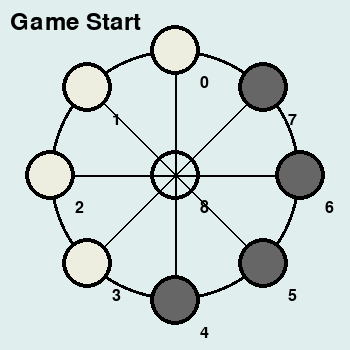

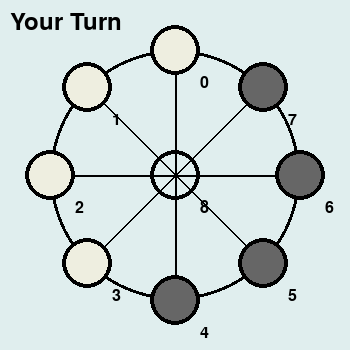

Valid moves: [0, 3]
Enter your move: 3


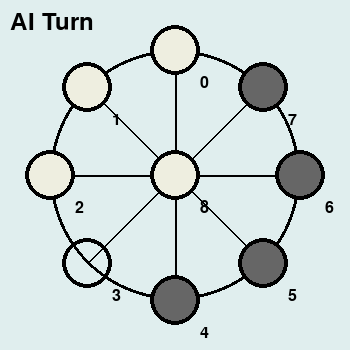

AI chose move: 4


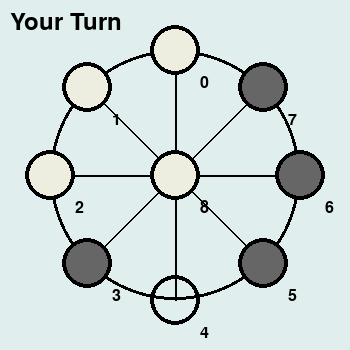

Valid moves: [8]
Enter your move: 8


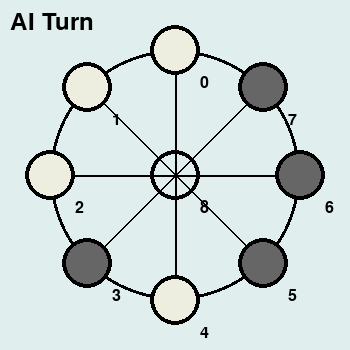

AI chose move: 3


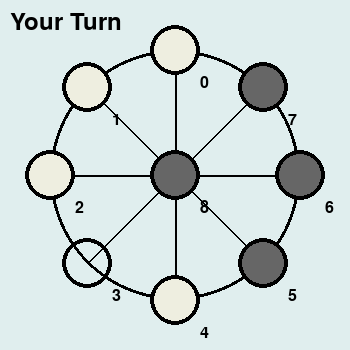

Valid moves: [2, 4]
Enter your move: 2


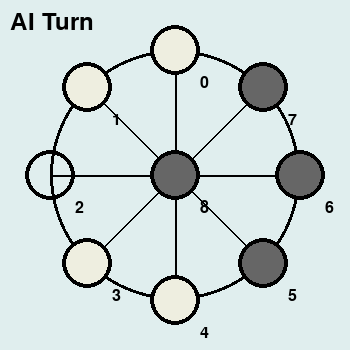

AI chose move: 8


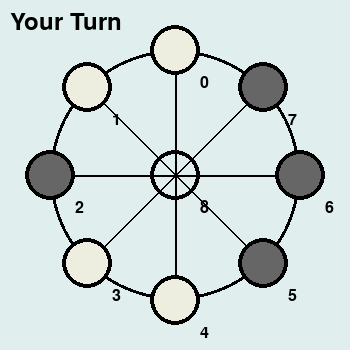

Valid moves: [0, 1, 3, 4]
Enter your move: 1


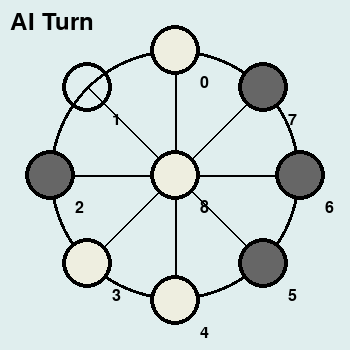

AI chose move: 2


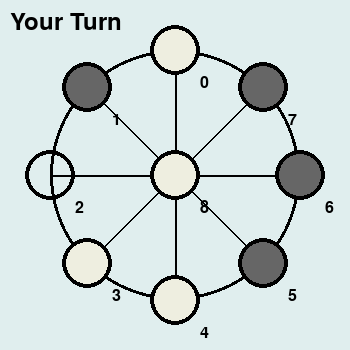

Valid moves: [3, 8]
Enter your move: 3


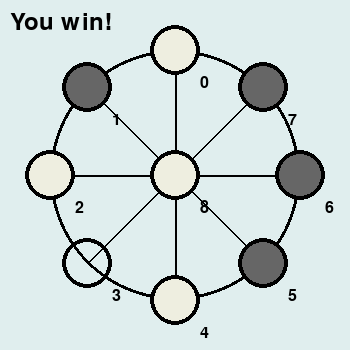

AI has learned from this game and improved its strategy.

Games played: 1
AI wins: 0
Human wins: 1
Draws: 0
Do you want to play again? (yes/no): yes

Welcome to Mu Torere!
The positions are numbered from 0 to 7 for the outer circle, and 8 for the center.
Do you want to play first? (yes/no): yes
You are playing as White (O)
The AI is playing as Black (X)


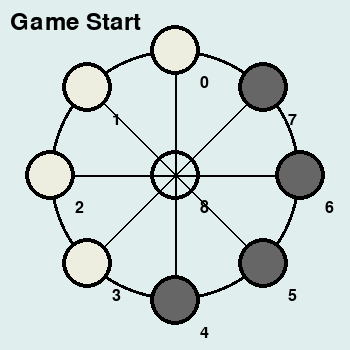

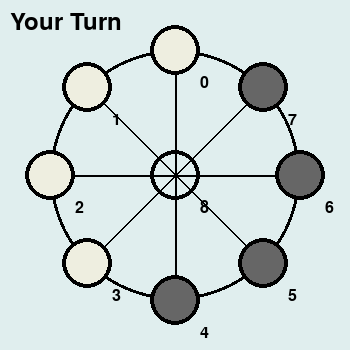

Valid moves: [0, 3]
Enter your move: 
Invalid input. Enter a number.
Enter your move: 3


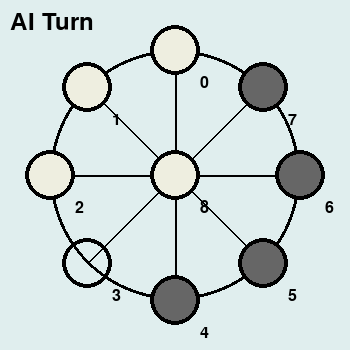

AI chose move: 4


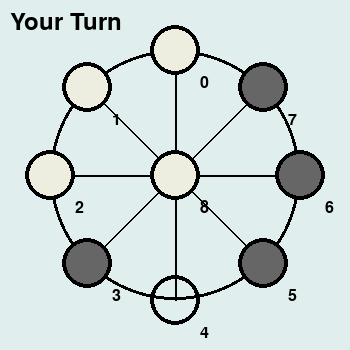

Valid moves: [8]
Enter your move: 8


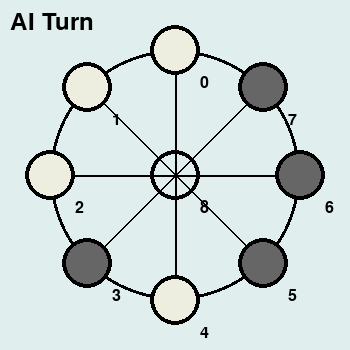

AI chose move: 3


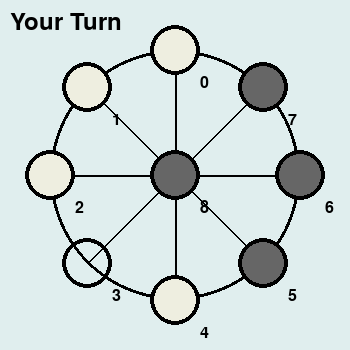

Valid moves: [2, 4]
Enter your move: 4


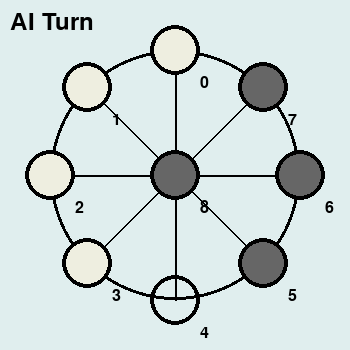

AI chose move: 5


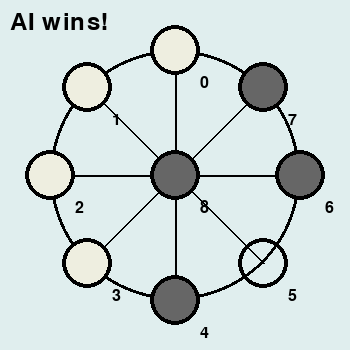

AI has learned from this game and improved its strategy.

Games played: 2
AI wins: 1
Human wins: 1
Draws: 0
Do you want to play again? (yes/no): yes

Welcome to Mu Torere!
The positions are numbered from 0 to 7 for the outer circle, and 8 for the center.
Do you want to play first? (yes/no): yes
You are playing as White (O)
The AI is playing as Black (X)


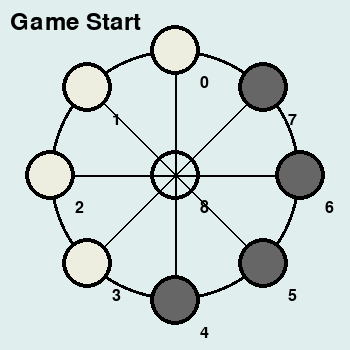

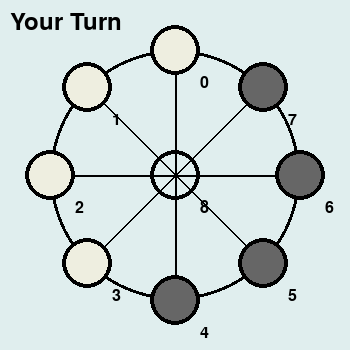

Valid moves: [0, 3]
Enter your move: 3


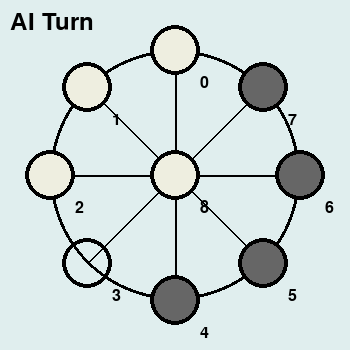

AI chose move: 4


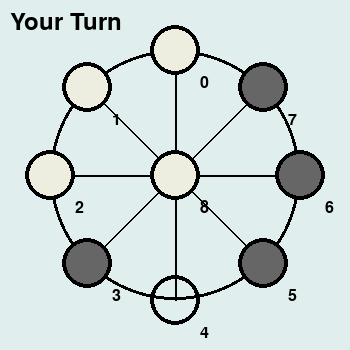

Valid moves: [8]
Enter your move: 8


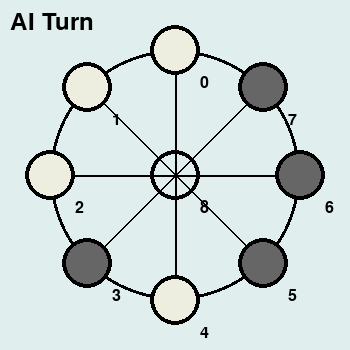

AI chose move: 5


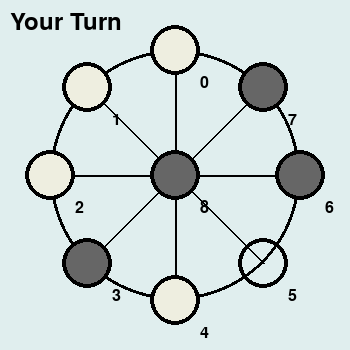

Valid moves: [4]
Enter your move: 4


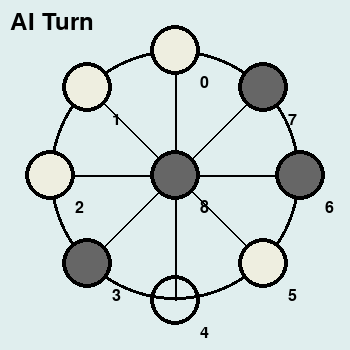

AI chose move: 8


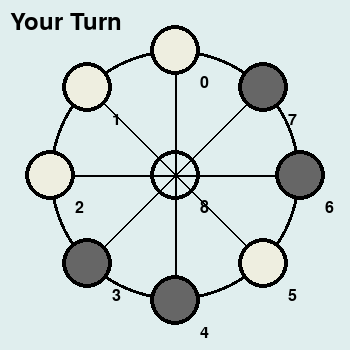

Valid moves: [0, 2, 5]
Enter your move: 2


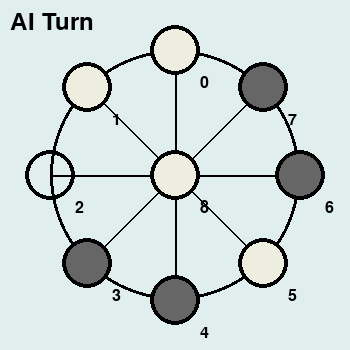

AI chose move: 3


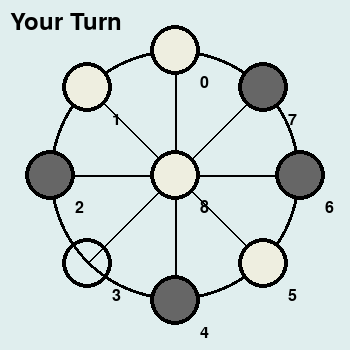

Valid moves: [8]
Enter your move: 8


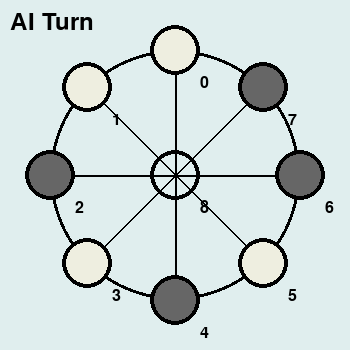

AI chose move: 4


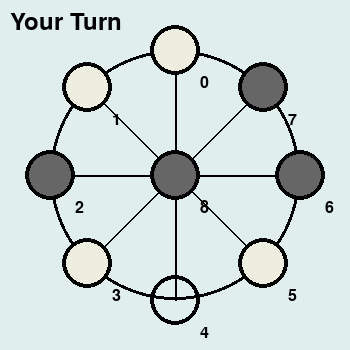

Valid moves: [3, 5]
Enter your move: 5


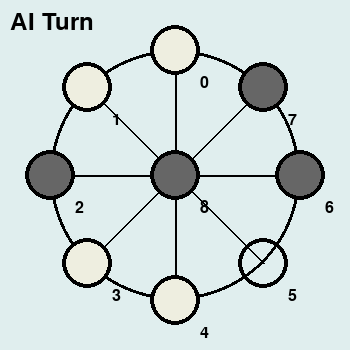

AI chose move: 6


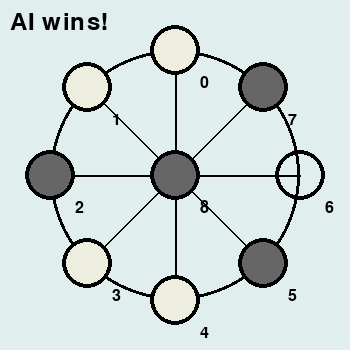

AI has learned from this game and improved its strategy.

Games played: 3
AI wins: 2
Human wins: 1
Draws: 0


KeyboardInterrupt: Interrupted by user

In [180]:
if __name__ == "__main__":
    q_table_file = 'q_table.pkl'

    if not os.path.exists(q_table_file):
        train_agents(episodes=100000, save_file=q_table_file)
    else:
        print("Loading pre-trained AI model.")

    games_played = 0
    ai_wins = 0
    human_wins = 0
    draws = 0

    while True:
        result = play_human_vs_agent(q_table_file)
        games_played += 1

        if "AI wins" in result:
            ai_wins += 1
        elif "You win" in result:
            human_wins += 1
        else:
            draws += 1

        print(f"\nGames played: {games_played}")
        print(f"AI wins: {ai_wins}")
        print(f"Human wins: {human_wins}")
        print(f"Draws: {draws}")

        play_again = input("Do you want to play again? (yes/no): ").strip().lower()
        if play_again != 'yes':
            print("Thank you for playing Mu Torere!")
            break